In [0]:
import pandas as pd
import numpy
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# fix random seed for reproducibility
import numpy as np
numpy.random.seed(10)
SEED = 42
import spacy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, f1_score
from keras.preprocessing.text import Tokenizer, text_to_word_sequence, one_hot
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt

import tensorflow as tf

import pickle
import itertools

import plotly
import plotly.graph_objs as go
from tqdm import tqdm
from sklearn.metrics import classification_report

Using TensorFlow backend.


# Aux functions

In [0]:
def train_test(df, proportion=[.7,.9]):
    train_df = pd.DataFrame() 
    dev_df = pd.DataFrame() 
    test_df = pd.DataFrame() 
    exercises_names = df['exercise.name'].unique()
    for exercise in exercises_names:
        df_exer = df[df['exercise.name'] == exercise]
        train, dev  = np.split(df_exer.sample(frac=1), [int(.7*len(df_exer))])
        print(train.shape, dev.shape, exercise)
        train_df = train_df.append(train, ignore_index=True)
        dev_df = dev_df.append(dev, ignore_index=True)
    return train_df, dev_df

In [0]:
class F1_Score(Callback):
    def __init__(self, training_data):
        self.training_data = training_data
        super().__init__() 

    def on_train_begin(self, logs={}):
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs={}):
        """
        train_predict = np.rint(self.model.predict(self.training_data[0]))
        train_targ = self.training_data[1]
        _train_f1 = f1_score(train_targ, train_predict, average='weighted')
        self.train_f1s.append(_train_f1)
        print(" — train_f1: %.4f" % _train_f1)
        """
        val_predict = np.rint(self.model.predict(self.validation_data[0]))
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average='weighted')
        print(classification_report(val_targ, val_predict))
        self.val_f1s.append(_val_f1)
        print(" — val_f1: %.4f" % _val_f1)
        return

In [0]:
def get_prediction(model, sub_content, max_length):
    return model.predict_proba(sequence.pad_sequences(sub_content,maxlen=max_length))

def print_header(data):
    print("Exercise Name: {}\nSupport: {}\nAccuracy: {p:.2f}".format(data[0], data[1][0], p=data[1][1]))

def print_tokenized(tokenizer, tokens):
    string = ''
    for token in tokens:
        string += tokenizer.index_word[token]+' '
    print(string)

def plot_distribution(x, exercise_name):
    plt.style.use('ggplot')
    plt.figure(figsize=(15,10))
    n, bins, patches = plt.hist(x, facecolor='b', alpha=0.75)
    plt.title(exercise_name+' exercise', size=30)
    plt.yticks(fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.grid(True)
    plt.show()
    
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

# Load Models and necessary stuff

In [0]:
import os
os.listdir('.')

['.config', 'sample_data']

In [0]:
from google.colab import files
uploaded = files.upload()

Saving test-df-IO-256-predicted2.pkl to test-df-IO-256-predicted2.pkl


In [0]:
#submissions = pd.read_pickle('test-df-intro-256-predicted.pkl')
submissions = pd.read_pickle('test-df-IO-256-predicted2.pkl')

In [0]:
from sklearn.model_selection import cross_validate

In [0]:
train_df = pd.read_pickle('train_df_intro_70.pkl')
test_df = pd.read_pickle('test_df_intro_30.pkl')
predicted_df = pd.read_pickle('test-df-intro-256-predicted.pkl')

In [0]:
info = {}
for student in submissions['student.email'].unique():
    #exer_df = submissions[submissions['exercise.name'] == exercise]
    info[student] = submissions[submissions['student.email'] == student].shape[0]


In [0]:
len(info.keys())

In [0]:
dic = {}
lst = []
for key, value in info.items():
    dic['exercise'] = key
    dic['proportion'] = value
    lst.append(dic)
    dic = {}

In [0]:
import csv
csv_columns = ['exercise','proportion']

csv_file = "test_proportion_intro.csv"
try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in lst:
            writer.writerow(data)
except IOError:
    print("I/O error") 

In [0]:
files.download('test_proportion_intro.csv')

In [0]:
df.to_pickle('IntroAlgo_df_final.pkl')
files.download('IntroAlgo_df_final.pkl')

In [0]:
df.columns

In [0]:
info = {}
for student in df['student.email'].unique():
    info[student] = (df[df['student.email'] == student]['exercise.name'].nunique(),#exercises attempted
                     df[(df['student.email'] == student) & (df['dropout_tray'])].shape[0], #dropouts
                     df[df['student.email'] == student].shape[0], #submissions amount
                     df[(df['student.email'] == student) & (df['dropout_tray'])].shape[0]/df[df['student.email'] == student].shape[0]) #proportion

In [0]:
info
primero = sorted(info.items(), key=lambda kv: -kv[1][3])
primero

In [0]:
bad_experience = df[df['student.email'] == 'nicosemiotica23@hotmail.com']
good_experience = df[df['student.email'] == 'pablinbor@gmail.com']

In [0]:
#train_df = df.drop(df[(df['student.email'] == 'pablinbor@gmail.com') | (df['student.email'] =='nicosemiotica23@hotmail.com')].index)
test_df = df[(df['student.email'] == 'nicosemiotica23@hotmail.com') | (df['student.email'] == 'pablinbor@gmail.com')]
 #'vale.pereyra27@gmail.com', 'seba1999gonzalez@gmail.com'

In [0]:
train_df.to_pickle('train_df_two_less_students_by_ration.pkl')

In [0]:
test_df.to_pickle('test_df_two_less_students_by_ratio.pkl')

In [0]:
files.download('train_df_two_less_students_by_ration.pkl')

# Build Model, Tokenizer and necessary stuff

In [0]:
# Tokenizer
with open('tokenizer-intro.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [0]:
model = load_model('introAlgo.06-0.46.h5')
#model = load_model('IO.10-0.81.h5')

W0813 14:48:44.014571 139782496139136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 14:48:44.063592 139782496139136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 14:48:44.082551 139782496139136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 14:48:44.374034 139782496139136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0813 14:48:44.386376 

# Accuracy for each exercise

In [0]:
acc_dict = {}
for exercise in submissions['exercise.name'].unique():
    df = submissions[submissions['exercise.name'] == exercise]
    acc = df[df['target'] == df['predicted_classes']].shape[0]/df.shape[0]
    acc_dict[exercise] = (df.shape[0], acc)

In [0]:
acc_sorted = sorted(acc_dict.items(), key=lambda kv: -kv[1][0])
acc_sorted

[('esBisiesto', (5903, 0.7323394883957309)),
 ('esMultiploDe', (3460, 0.7170520231213873)),
 ('esMultiploDeTres', (3049, 0.702853394555592)),
 ('haceFrioF', (2271, 0.7793923381770145)),
 ('Puntos Para Setenta!', (1993, 0.7631710988459609)),
 ('Composición', (1516, 0.8449868073878628)),
 ('promediosSinAplazos', (1150, 0.7452173913043478)),
 ('esCuadradoPerfecto', (1093, 0.8023787740164684)),
 ('Pinos', (1091, 0.8881759853345554)),
 ('Más composición', (1023, 0.8357771260997068)),
 ('Dispersión', (960, 0.8083333333333333)),
 ('Más valores', (904, 0.8926991150442478)),
 ('Combinando funciones', (900, 0.8822222222222222)),
 ('Valores y variables', (878, 0.8633257403189066)),
 ('Orden de las Condiciones', (824, 0.8046116504854369)),
 ('Iterar', (821, 0.7539585870889159)),
 ('Los números', (768, 0.9049479166666666)),
 ('Más funciones', (729, 0.8600823045267489)),
 ('Tipando tuplas', (725, 0.8110344827586207)),
 ('Múltiples parámetros', (707, 0.917963224893918)),
 ('Los operadores son funcion

# Best Acc

Exercise Name: esBisiesto
Support: 5903
Accuracy: 0.73


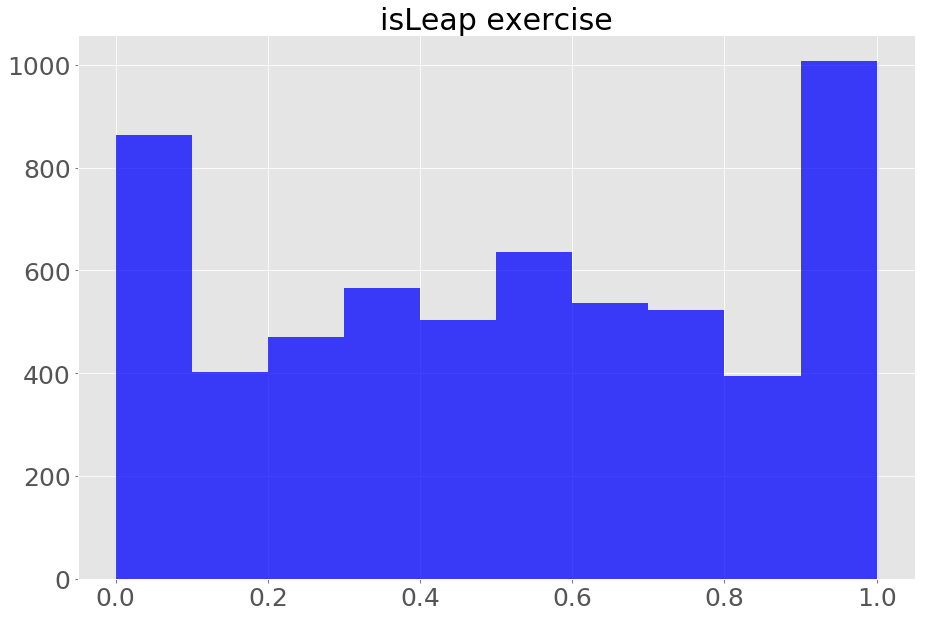

In [0]:
print_header(acc_sorted[0])
plot_distribution(submissions[submissions['exercise.name']=='esBisiesto']['predicted'], 'isLeap')

Exercise Name: haceFrioF
Support: 215
Accuracy: 0.82


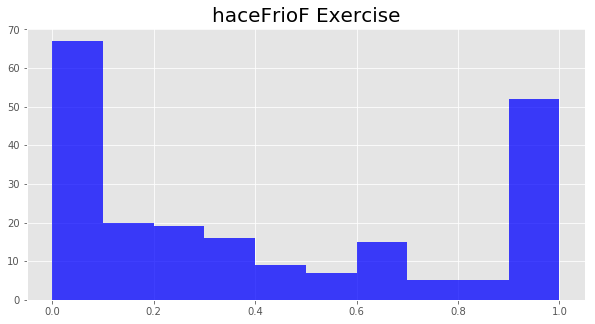

In [0]:
print_header(acc_sorted[2])
plot_distribution(submissions[submissions['exercise.name']=='haceFrioF']['predicted'], 'haceFrioF')

Exercise Name: Pinos
Support: 208
Accuracy: 0.89


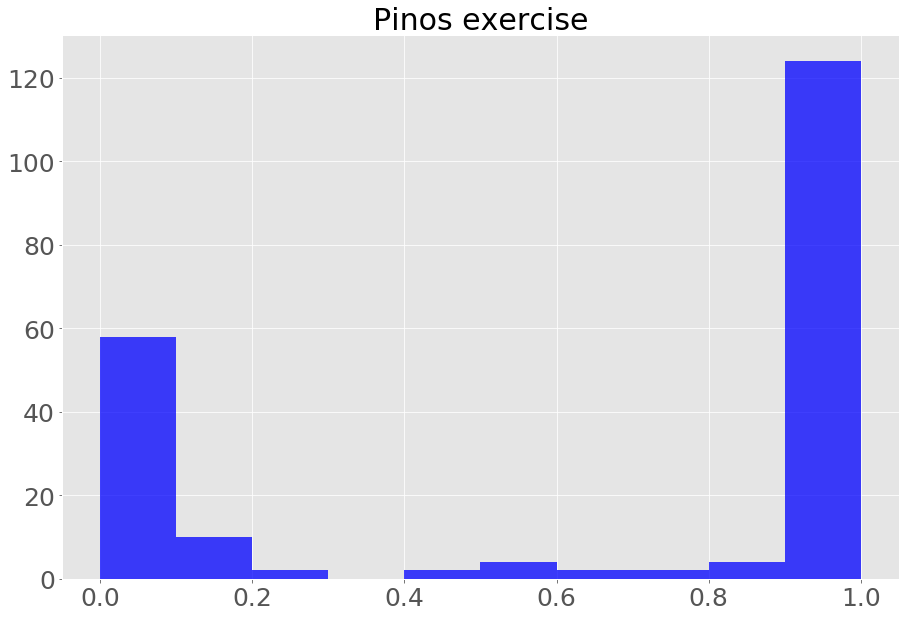

In [0]:
print_header(acc_sorted[3])
plot_distribution(submissions[submissions['exercise.name']=='Pinos']['predicted'], 'Pinos')

Exercise Name: Días
Support: 167
Accuracy: 0.88


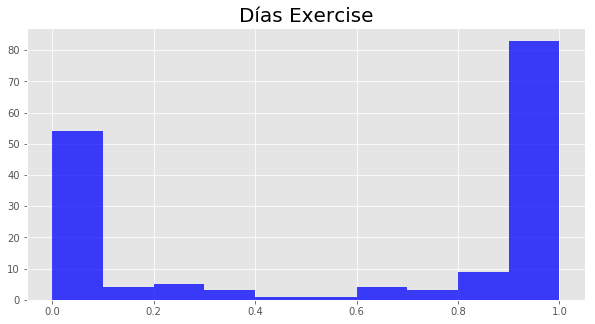

In [0]:
print_header(acc_sorted[6])
plot_distribution(submissions[submissions['exercise.name']=='Días']['predicted'], 'Días')

# Experimental Zone

In [0]:
exercises = [ 'esBisiesto', 'esMultiploDeTres', 'haceFrioF', 'Pinos',
    'Orden de las Condiciones', 'Dispersión', 'Días',
             'No todo lo que brilla es Oro']
df = pd.DataFrame()
for exercise in exercises:
    df = df.append(submissions[submissions['exercise.name'] == exercise].sample(n=5, random_state=42)[['content', 'exercise.name','target','predicted_classes', 'predicted']])

In [0]:
for index, row in submissions.iloc[index_tag_exercises].iterrows():
    print(row['submissions_status'])

In [0]:
index_tag_exercises = [297,327,537,441,274,3861,3992,3929,3790,3863,4541,
                       4553,4479,4517,4356,3445,3299,3357,3380,3450,1656,
                       1650,1741,1773,1709,4179,4202,4313,4238,4305,3593,
                       3600,3570,3548,3590,2656,2735,2684,2670,2723]
for index, row in submissions.iloc[index_tag_exercises].iterrows():
    print(row['content'] + '\n')

In [0]:
for elem in df['content'].values:
    print(elem)
    print("--------------------")

In [0]:
esBisiesto_df = submissions[submissions['exercise.name']=='esBisiesto']

In [0]:
print(esBisiesto_df[['content', 'exercise.name','target','predicted_classes', 'predicted']].sort_values('predicted', ascending=False).loc[559]['content'])
print(esBisiesto_df[['content', 'exercise.name','target','predicted_classes', 'predicted']].sort_values('predicted', ascending=False).loc[559]['predicted'])

In [0]:
for index, row in esBisiesto_df[(esBisiesto_df['target'] == 1) & (esBisiesto_df['predicted'] >= 0.7)][['content', 'exercise.name','target','predicted_classes', 'predicted']].sort_values('predicted').iloc[-40:].iterrows():
    print(row.content)
    print(row.predicted)
    print("============ \n")
#esBisiesto_df[esBisiesto_df['student.email'] == 'pl.roldan1@gmail.com'].loc[490]#['content']
#print(esBisiesto_df.loc[4207]['content'])


In [0]:
#exer = [submissions.loc[exer_id]['content']][0].replace('&&', '||')
exer = 'esBisiesto x = (esMultiploDe x 400) || ((esMultiploDe x 4) && not(esMultiploDe x 100)) '
exer

In [0]:
exer_id = 274
#exer_id = 607
#Tokenizo la solucion
#tokenized = tokenizer.texts_to_sequences([submissions.loc[exer_id]['content']])[0]

tokenized = tokenizer.texts_to_sequences([exer])[0]

#ventada de 1, voy sacando de a un token y padeo 
to_train = [(tokenized[i], tokenized[:i]+tokenized[i+1:]) for i in range(len(tokenized))]

print(submissions.loc[exer_id]['predicted_classes'])
print(submissions.loc[exer_id]['predicted'])
print(submissions.loc[exer_id]['content'])

for i in tokenizer.texts_to_sequences([submissions.loc[exer_id]['content']]):
    print(i)
#to_train

In [0]:
print_tokenized(tokenizer,tokenized)
print(get_prediction(model, [tokenized], 100)[0][0])
print('\n')


for elem in to_train:
    print("Remove token {}".format(tokenizer.index_word[elem[0]]))
    print_tokenized(tokenizer, elem[1])
    print(get_prediction(model, [elem[1]], 100)[0][0])
    print('\n')

In [0]:
lst = np.array([])
predicted = {}
for i in range(len(tokenized)):
    lst = tokenized[:i+1]
    predicted[i] = (get_prediction(model, [lst], 100)[0][0], lst)

In [0]:
values = []
for elem in list(predicted.values()):
    tokens = elem[1]
    string = ''
    for token in tokens:
        string += tokenizer.index_word[token] + ' '
    values.append(string)

In [0]:
predictions = [elem[0] for elem in list(predicted.values())]

In [0]:
for elem in predicted.values():
    print("Score {}".format(elem[0]))
    print_tokenized(tokenizer, elem[1])
    print()

In [0]:
values

In [0]:

configure_plotly_browser_state()
plotly.offline.init_notebook_mode(connected=True)

trace = go.Heatmap(z=predictions,
                   x=list(predicted.keys()),
                   y=values)
data=[trace]
plotly.offline.iplot(data, filename='labelled-heatmap')

In [0]:
esBisiesto_df[(esBisiesto_df['target'] == 1) & (esBisiesto_df['predicted'] >= 0.7)][['content', 'exercise.name','target','predicted_classes', 'predicted']]

In [0]:
df.to_excel("anotation.xls")

# A new beatiful set of experiments

Top 5 exercises sorted by submissions to test.

In [0]:
sorted(acc_dict.items(), key=lambda x : -x[1][0])[:6]

In [0]:
most_frequent = [elem[0] for elem in sorted(acc_dict.items(), key=lambda x : -x[1][0])[:6]]
most_frequent

Last 5 exercises sorted by submissions to test.

In [0]:
sorted(acc_dict.items(), key=lambda x : -x[1][0])[-5:]

In [0]:
less_frequent = [elem[0] for elem in sorted(acc_dict.items(), key=lambda x : -x[1][0])[-5:]]
less_frequent

In [0]:
def calculate_f1(submissions, exercise_names):
    res = {}
    for exercise in exercise_names:
        y_true = submissions[submissions['exercise.name'] == exercise]['target']
        y_pred = submissions[submissions['exercise.name'] == exercise]['predicted_classes']
        ## AGREGAR WEIGHTED ACAAAAAAAAAAAAAAAA
        res[exercise] = f1_score(y_true, y_pred, average='weighted')
    return res

In [0]:
calculate_f1(submissions, most_frequent)

In [0]:
calculate_f1(submissions, less_frequent)

In [0]:
all_exercise = [elem[0] for elem in sorted(acc_dict.items(), key=lambda x : -x[1][0])]

In [0]:
submissions = pd.read_pickle('test-df-IO-256-predicted2.pkl')

In [0]:
all_exercise = submissions['exercise.name'].unique()

In [0]:
f1s = calculate_f1(submissions, all_exercise)

In [0]:

f1s

In [0]:
train_df = pd.read_pickle('train_df_IO.pkl')
test_df = pd.read_pickle('test_df_IO.pkl')

In [0]:
import tensorflow as tf
from keras import backend as K

def super_network(exercise_name, train_df, test_df, f1=False):
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    sess = tf.Session(config=config)
    K.set_session(sess)

    data_dict = {}
    exer_train_df = train_df[train_df['exercise.name'] == exercise_name]
    exer_test_df = test_df[test_df['exercise.name'] == exercise_name]

    X_train = exer_train_df['content'].values
    Y_train = exer_train_df['target'].values
    X_test = exer_test_df['content'].values
    Y_test = exer_test_df['target'].values

    max_length = 100
    top_words = 5000
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    X_train = sequence.pad_sequences(X_train, maxlen=max_length)
    X_test = sequence.pad_sequences(X_test, maxlen=max_length)

    callbacks = [F1_Score((X_train, Y_train)), ModelCheckpoint("Super-network-"+str(exercise_name)+".{epoch:02d}-{val_loss:.2f}.h5", monitor="val_loss", save_best_only=True, period=1)]

    # create the model
    embedding_vecor_length = 256
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=max_length))
    model.add(LSTM(100))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(exercise_name+'\n')
    print(model.summary())
    res = model.fit(np.array(X_train), Y_train, validation_data=(np.array(X_test), Y_test), epochs=10, batch_size=32, callbacks=callbacks)
    if f1:
        info_tup = (X_test.shape[0], callbacks[0].val_f1s[-1])
    else:
        info_tup = (X_test.shape[0], model.history.history['val_acc'][-1])
            
    K.clear_session()
    return info_tup

In [0]:
data_dict = {}
for exercise in tqdm(train_df['exercise.name'].unique()):
    data_dict[exercise] = super_network(exercise, train_df, test_df, False)

In [0]:
data_dict

In [0]:
pickle_out = open("dict_1exer_1network.pkl","wb")
pickle.dump(data_dict, pickle_out)
pickle_out.close()

In [0]:
acc = 0
avg = 0
denom = 0
for elem in data_dict.values():
    acc += elem[0]*elem[1]
    denom += elem[0]

print(acc/denom)

In [0]:
sorted(data_dict.items(), key=lambda kv : -kv[1][0])

In [0]:
from google.colab import files
files.download('dict_1exer_1network.pkl')

In [0]:
with (open("dict_1exer_1network.pkl", "rb")) as openfile:
    exer_dic = pickle.load(openfile)

In [0]:
acc = 0
avg = 0
denom = 0
for elem in exer_dic.values():
    acc += elem[0]*elem[1]
    denom += elem[0]

print(acc/denom)

{'Dispersión': (181, 0.7652459155810826),
 'Días': (167, 0.8686666305977379),
 'No todo lo que brilla es Oro': (152, 0.8473044726085528),
 'Orden de las Condiciones': (205, 0.824202992843201),
 'Pinos': (208, 0.9062048121370155),
 'esBisiesto': (407, 0.7849954447512929),
 'esMultiploDeTres': (268, 0.6817535603643089),
 'haceFrioF': (215, 0.840480847663598)}

## Most used 

New
- esBisiesto tested over 407 examples 0.84 best f1
- esMultiplodeTres tested over 268 examples 0.77 best f1
- PInos tested over 208 examples 0.89 best f1
- Orden de las Condiciones  tested over 205 best f1 0.85
- haceFrioF tested over 215 best f1 0.80
- Dispersión tested over 181 best f1 0.83

Old
- 'Dispersión': 0.8412017167381974,
- 'Orden de las Condiciones': 0.8549019607843139,
- 'Pinos': 0.920863309352518,
-  'esBisiesto': 0.8712871287128713,
- 'esMultiploDeTres': 0.7828746177370031,
- 'haceFrioF': 0.7796610169491526
 
|  exercise  | tested amount | Previous F1 | New F1 | 
|-------------|:---------:|:-------------:|:---------:|
| esBisiesto | 407 |  0.87  | 0.84   |
| esMultiplodeTres | 268 |  0.78  | 0.77   |
| Pinos | 268 |  0.92  | 0.89   |
| OrdendeLasCondiciones | 205 |  0.85  | 0.85 |
| HaceFrioF | 215 |  0.77 | 0.80 |
| Dispersion | 181 |  0.84 | 0.83 |





## less used


|  exercise  | tested amount | Previous F1 | New F1 | 
|-------------|:---------:|:-------------:|:---------:|
| iterar | 14 |  0.71  | 0.44   |
| alVesre | 18 |  0.84  | 0.82   |
| aplanar | 14 |  0.90  | 0.89   |
| intercalar | 20 |  0.72  | 0.57 |
| zipWith | 14 |  0.72 | 0.68 |



In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
os.listdir('.')

In [0]:
train_io = pd.read_pickle('train_df_IO (1).pkl')
test_io = pd.read_pickle('test_df_IO.pkl')

In [0]:
X_train = train_io['content'].values
Y_train = train_io['target'].values
X_test = test_io['content'].values
Y_test = test_io['target'].values

In [0]:
tokenizer = Tokenizer(num_words=35000, oov_token="<UNK>", filters='', lower=False)
tokenizer.fit_on_texts(X_train)

In [0]:
with open('tokenizer-IO.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
files.download('tokenizer-IO.pkl')

In [0]:
max_length = 100
top_words = 5000
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [0]:
X_train = sequence.pad_sequences(X_train, maxlen=max_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_length)

In [0]:
import tensorflow as tf
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
sess = tf.Session(config=config)
K.set_session(sess)
    
callbacks = [F1_Score((X_train, Y_train)), ModelCheckpoint("IO.{epoch:02d}-{val_loss:.2f}.h5", monitor="val_loss", save_best_only=True, period=1)]

# create the model
embedding_vecor_length = 256
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_length))
model.add(LSTM(100))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
res = model.fit(np.array(X_train), Y_train, validation_data=(np.array(X_test), Y_test), epochs=20, batch_size=32, callbacks=callbacks)

In [0]:
data_dict_io = {}
for exercise in tqdm(train_io['exercise.name'].unique()):
    data_dict_io[exercise] = super_network(exercise, train_io, test_io, False)

In [0]:
pickle_out = open("dict_1exer_1network-IO.pkl","wb")
pickle.dump(data_dict_io, pickle_out)
pickle_out.close()

In [0]:
train_df[train_df['exercise.name'] == 'Cubo']

In [0]:
files.download('dict_1exer_1network-IO.pkl')

In [0]:
acc = 0
avg = 0
denom = 0
for elem in data_dict_io.values():
    acc += elem[0]*elem[1]
    denom += elem[0]

print(acc/denom)

In [0]:
import os
import pickle
os.listdir('.')

In [0]:
with (open("dict_1exer_1network.pkl", "rb")) as openfile:
    exer_dic = pickle.load(openfile)

In [0]:
with (open("dict_1exer_1network-IO.pkl", "rb")) as openfile:
    exer_dic_io = pickle.load(openfile)

In [0]:
def weighted_avg(df):
    acc = 0
    avg = 0
    denom = 0
    for elem in df.values():
        acc += elem[0]*elem[1]
        denom += elem[0]

    return acc/denom

## Weighted Average Intro

In [0]:
print(weighted_avg(exer_dic))

## Weighted Average IO

In [0]:
print(weighted_avg(exer_dic_io))

In [0]:
acc = 0
avg = 0
index = 0
for elem in exer_dic.values():
    acc += elem[1]
    index += 1
avg = acc/index
print(avg)

In [0]:
acc = 0
avg = 0
index = 0
for elem in exer_dic_io.values():
    acc += elem[1]
    index += 1
avg = acc/index
print(avg)

In [0]:
files.upload()

In [0]:
dic = {}
lst = []
for key, value in data_dict.items():
    dic['exercise'] = key
    dic['support'] = value[0]
    dic['accuracy'] = value[1]
    lst.append(dic)
    dic = {}

In [0]:
lst

In [0]:
import csv
csv_columns = ['exercise','support','accuracy']

csv_file = "big_network_io_accuracy.csv"
try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in lst:
            writer.writerow(data)
except IOError:
    print("I/O error") 

In [0]:
from google.colab import files
files.download("big_network_io_accuracy.csv")

In [0]:
test_io[test_io['exercise.name'] == 'Cubo']
#train_io[train_io['exercise.name'] == 'Cubo']

In [0]:
os.listdir(".")

In [0]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [0]:
import tensorflow as tf
from keras import backend as K

def fold_network_student(students, df, tokenizer, f1=False):
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.7
    sess = tf.Session(config=config)
    K.set_session(sess)

    data_dict = {}
    exer_train_df = df[~df['student.email'].isin(students)]
    exer_test_df = df[df['student.email'].isin(students)]

    X_train = exer_train_df['content'].values
    Y_train = exer_train_df['target'].values
    X_test = exer_test_df['content'].values
    Y_test = exer_test_df['target'].values

    max_length = 100
    top_words = 5000
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    X_train = sequence.pad_sequences(X_train, maxlen=max_length)
    X_test = sequence.pad_sequences(X_test, maxlen=max_length)

    callbacks = [F1_Score((X_train, Y_train)), ModelCheckpoint("Fold-network-.{epoch:02d}-{val_loss:.2f}.h5", monitor="val_loss", save_best_only=True, period=1)]

    # create the model
    embedding_vecor_length = 256
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=max_length))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(students)
    print(model.summary())
    res = model.fit(np.array(X_train), Y_train, validation_data=(np.array(X_test), Y_test), epochs=10, batch_size=32, callbacks=callbacks)
    if f1:
        info_tup = (exer_train_df[exer_train_df['dropout_tray']].shape[0], exer_train_df.shape[0], 
                    exer_train_df[exer_train_df['dropout_tray']].shape[0] / exer_train_df.shape[0], 
                    exer_test_df[exer_test_df['dropout_tray']].shape[0],
                    exer_test_df.shape[0],
                    exer_test_df[exer_test_df['dropout_tray']].shape[0] / exer_test_df.shape[0],
                    max(callbacks[0].val_f1s))
    else:
        info_tup = (exer_train_df[exer_train_df['dropout_tray']].shape[0], exer_train_df.shape[0], 
                    exer_train_df[exer_train_df['dropout_tray']].shape[0] / exer_train_df.shape[0], 
                    exer_test_df[exer_test_df['dropout_tray']].shape[0],
                    exer_test_df.shape[0],
                    exer_test_df[exer_test_df['dropout_tray']].shape[0] / exer_test_df.shape[0], max(model.history.history['val_acc']))
            
    K.clear_session()
    return info_tup

In [0]:
tokenizer = Tokenizer(num_words=35000, oov_token="<UNK>", lower=False, filters='')
tokenizer.fit_on_texts(submissions['content'])

In [0]:
network_fold = {}
index = 1
for elem in tqdm(list(chunks(submissions['student.email'].unique(), 339))):
    network_fold[index] = fold_network_student(list(elem), submissions, tokenizer, True)
    index += 1

In [0]:
network_fold

In [0]:
dic = {}
lst = []
for key, value in network_fold.items():
    dic['fold_number'] = key
    dic['dropout_train'] = value[0]
    dic['examples_train'] = value[1]
    dic['ratio_train'] = value[2]
    dic['dropout_test'] = value[3]
    dic['examples_test'] = value[4]
    dic['ratio_test'] = value[5]
    dic['f1'] = value[6]
    lst.append(dic)
    dic = {}

In [0]:
import csv
csv_columns = ['fold_number','dropout_train','examples_train', 'ratio_train', 'dropout_test','examples_test', 'ratio_test', 'f1']

csv_file = "fold_network_intro.csv"
try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in lst:
            writer.writerow(data)
except IOError:
    print("I/O error") 

In [0]:
files.download('fold_network_intro.csv')

# Fold by submissions

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
tokenizer = Tokenizer(num_words=35000, oov_token="<UNK>", lower=False, filters='')
tokenizer.fit_on_texts(submissions['content'])

In [0]:
X = submissions['content'].values
Y = submissions['target'].values

max_length = 100
top_words = 5000
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen=max_length)

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
cvscores = []
for train, test in kfold.split(X, Y):
    callbacks = [F1_Score((X[train], Y[train])), ModelCheckpoint("Fold-network-.{epoch:02d}-{val_loss:.2f}.h5", monitor="val_loss", save_best_only=True, period=1)]

    # create the model
    embedding_vecor_length = 256
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=max_length))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    res = model.fit(np.array(X[train]), Y[train], validation_data=(np.array(X[test]), Y[test]), epochs=1, batch_size=32, callbacks=callbacks)
    cvscores.append(max(callbacks[0].val_f1s))

# De Malo a bueno

In [0]:
#predicted_df[(predicted_df['exercise.name'] == 'esBisiesto') & (predicted_df['target'] == 0)][['content', 'target', 'predicted']].iloc[0]['content']
for i in range(20):
    exer = predicted_df[(predicted_df['exercise.name'] == 'esBisiesto') & (predicted_df['predicted'] > 0.4) & (predicted_df['predicted'] < 0.6) & (predicted_df['target'] == 1)][['content', 'target', 'predicted']].sort_values('predicted', ascending=False).iloc[i]
    print(i, exer['content'], exer['predicted'], '\n')

0 esBisiesto :: Float -> Bool
esBisiesto n = esMultiploDe n 400 || esMultiploDe n 4 not 100 0.5961923 

1 esBisiesto :: Float -> Bool
esBisiesto n = esMultiploDe n 400 || esMultiploDe n 4 not 100 0.5961923 

2 esBisiesto = (esMultiploDe 400)
 0.5936166 

3 esBisiesto n = (esMultiploDe 400 n) 0.58657736 

4 esBisiesto esMultiploDe x = mod x 0.58201754 

5 esBisiesto :: Int -> Int -> Bool
esBisiesto n = not (esMultiploDe n)  0.5727112 

6 esBisiesto n = (esMultiploDe n 400) 0.5684053 

7 esBisiesto x = esMultiploDe x 100 0.55742866 

8 esBisiesto x = esMultiploDe x (4 not 100) 0.55309427 

9 esBisiesto :: Float -> Float -> Bool
esBisiesto esMultiploDe num = esMultiploDe num 400 == 0 || esMultiploDe num 4 == 0  0.5514641 

10 esBisiesto x = esMultiploDe x 4 not (esMultiploDe 100) 0.54279935 

11 esBisiesto x  = (esMultiploDe 4 x ) && ( esMultiploDe 400 x ) && not ( esMultiploDe 100 x )  0.53530395 

12 esBisiesto:: Int->Bool
esBisiesto n= 

esMultiploDe n 400 
  0.53469974 

13 esBisiesto

In [0]:
for i in range(40):
    exer = predicted_df[(predicted_df['exercise.name'] == 'esBisiesto') & (predicted_df['target'] == 1)][['content', 'target', 'predicted']].sort_values('predicted', ascending=False).iloc[i]
    print("{} {} {} \n".format(i, exer['content'], exer['predicted']))


In [0]:
def predict_a_attemp(model, exercise, tokenizer):
    prediction = 0
    tokenized = tokenizer.texts_to_sequences([exercise])[0]
    prediction = get_prediction(model, [tokenized], 100)[0][0]
    return prediction

In [0]:
exer = 'esBisiesto n = esMultiploDe n 400  || (not (esMultiploDe n 100) && (esMultiploDe n 4))'
tokenized = tokenizer.texts_to_sequences([exer])[0]
#print(tokenized)
print(get_prediction(model, [tokenized], 100))


[[0.00036595]]


In [0]:
atte = 'esBisiesto esMultploDe x*4 = x*4'
attem = 'esBisiesto x=not esMultiploDe x 4'
attemp = 'esBisiesto 400=not esMultiploDe 400 100'
attemp_0 = 'esBisiesto = mod 400 4 && not (mod 100)'
attemp_1 = 'esBisiesto = mod n 400 4 && not (mod n 100)'
attemp_2 = 'esBisiesto n = mod n 400 4 && not (mod n 100)'
attemp_3 = 'esBisiesto n = mod n 400  && not (mod n 100)'
attemp_4 = 'esBisiesto n = mod n 400 == 0  && not (mod n 100 == 0)'
attemp_5 = 'esBisiesto n = mod n 400 == 0  && not (mod n 100 == 0) && (mod n 4 == 0)'
attemp_6 = 'esBisiesto n = mod n 400 == 0  || not (mod n 100 == 0) && (mod n 4 == 0)'
attemp_7 = 'esBisiesto n = esMultiploDe n 400  && not (esMultiploDe n 100)'
attemp_8 = 'esBisiesto n = esMultiploDe n 400  && not (esMultiploDe n 100) && (esMultiploDe n 4)'
attemp_9 = 'esBisiesto n = esMultiploDe n 400  || not (esMultiploDe n 100) && (esMultiploDe n 4)'
attemp_10 = 'esBisiesto n = (esMultiploDe n 400) || ((esMultiploDe n 4) && not(esMultiploDe n 100))'

In [0]:
lst = [atte, attem, attemp, attemp_0, attemp_1, attemp_2, attemp_3, attemp_4, attemp_5, attemp_6, attemp_7,attemp_8, attemp_9, attemp_10]
res = []
index = 1
dic = {}
for elem in lst:
    print(elem, predict_a_attemp(model, elem, tokenizer))
    index += 1

esBisiesto esMultploDe x*4 = x*4 0.99994385
esBisiesto x=not esMultiploDe x 4 0.9997271
esBisiesto 400=not esMultiploDe 400 100 0.99894315
esBisiesto = mod 400 4 && not (mod 100) 0.9853784
esBisiesto = mod n 400 4 && not (mod n 100) 0.9183582
esBisiesto n = mod n 400 4 && not (mod n 100) 0.86685973
esBisiesto n = mod n 400  && not (mod n 100) 0.7896689
esBisiesto n = mod n 400 == 0  && not (mod n 100 == 0) 0.618492
esBisiesto n = mod n 400 == 0  && not (mod n 100 == 0) && (mod n 4 == 0) 0.3098392
esBisiesto n = mod n 400 == 0  || not (mod n 100 == 0) && (mod n 4 == 0) 0.22220014
esBisiesto n = esMultiploDe n 400  && not (esMultiploDe n 100) 0.23816271
esBisiesto n = esMultiploDe n 400  && not (esMultiploDe n 100) && (esMultiploDe n 4) 0.011356719
esBisiesto n = esMultiploDe n 400  || not (esMultiploDe n 100) && (esMultiploDe n 4) 0.006454925
esBisiesto n = (esMultiploDe n 400) || ((esMultiploDe n 4) && not(esMultiploDe n 100)) 0.0013494304


In [0]:
dic

{}